JITコンパイル中...（初回のみ時間がかかります）
最適化を開始します...


100%|██████████| 100/100 [04:00<00:00,  2.40s/it]


最適化完了 (100ステップ, 240.238 秒)

最終的な最適デバイス長: 2411.7 um
その時のSHG変換効率: 75.1048%


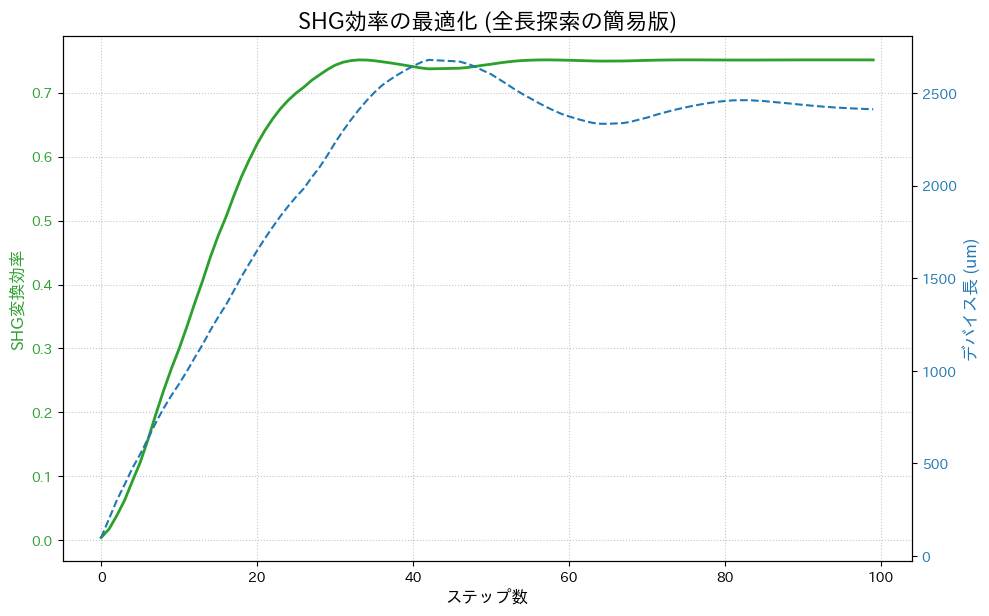

In [ ]:
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
import time

from qpm import mgoslt, cwes

Z_MAX = 10000.0  # 考慮する最大デバイス長 (um)
KAPPA_MAG = jnp.arctanh(jnp.sqrt(0.95)) / 2000 * 2 / jnp.pi
DESIGN_TEMP_C = 70.0
DESIGN_WAVELENGTH = 1.031

DELTA_K_SHG = mgoslt.calc_twm_delta_k(
    DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, DESIGN_TEMP_C)
DELTA_K_SHG = mgoslt.calc_twm_delta_k(
    DESIGN_WAVELENGTH, DESIGN_WAVELENGTH / 2.0, DESIGN_TEMP_C)
DOMAIN_LEN_SHG = jnp.pi / DELTA_K_SHG
MAX_TOTAL_DOMAINS = int(jnp.ceil(Z_MAX / DOMAIN_LEN_SHG))
DOMAIN_INDICES = jnp.arange(MAX_TOTAL_DOMAINS)
ALTERNATING_SIGN = jnp.power(-1.0, DOMAIN_INDICES)
B_INITIAL = jnp.array([jnp.sqrt(0.5), jnp.sqrt(0.5), 0.0], dtype=jnp.complex64)


def loss_and_aux_fn(total_length_param: jnp.ndarray):
    total_length = total_length_param[0]

    num_active_domains = total_length / DOMAIN_LEN_SHG

    steepness = 10.0
    active_mask = jax.nn.sigmoid(
        steepness * (num_active_domains - DOMAIN_INDICES))

    h_total = DOMAIN_LEN_SHG * active_mask
    kappa_total = KAPPA_MAG * ALTERNATING_SIGN * active_mask
    superlattice = jnp.stack([h_total, kappa_total], axis=1)

    efficiencies = cwes.simulate_twm(
        superlattice, DELTA_K_SHG, DELTA_K_SHG, B_INITIAL)

    sfg_efficiency = efficiencies[1]
    loss = -sfg_efficiency

    return loss, (sfg_efficiency, total_length)


def run_optimization():
    learning_rate = 100.0
    num_steps = 100
    optimizer = optax.adam(learning_rate)

    initial_params = jnp.array([100.0])
    opt_state = optimizer.init(initial_params)
    params = initial_params

    value_and_grad_fn = jax.value_and_grad(loss_and_aux_fn, has_aux=True)

    @jax.jit
    def optimization_step(params, opt_state):
        (loss, aux_data), grads = value_and_grad_fn(params)
        updates, opt_state = optimizer.update(grads, opt_state)
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss, aux_data

    history = {"shg_eff": [], "length": []}

    print("JITコンパイル中...（初回のみ時間がかかります）")
    optimization_step(params, opt_state)
    print("最適化を開始します...")

    start_time = time.perf_counter()
    for _ in tqdm(range(num_steps)):
        params, opt_state, loss, (shg_eff, current_length) = optimization_step(
            params, opt_state)

        history["shg_eff"].append(shg_eff)
        history["length"].append(current_length)

    jax.block_until_ready(history)
    end_time = time.perf_counter()
    print(f"最適化完了 ({num_steps}ステップ, {end_time - start_time:.3f} 秒)")

    final_length = history["length"][-1]
    final_shg_eff = history["shg_eff"][-1]

    print(f"\n最終的な最適デバイス長: {final_length:.1f} um")
    print(f"その時のSHG変換効率: {final_shg_eff:.4%}")

    fig, ax1 = plt.subplots(figsize=(10, 6))

    color = 'tab:green'
    ax1.set_xlabel("ステップ数", fontsize=12)
    ax1.set_ylabel("SHG変換効率", fontsize=12, color=color)
    ax1.plot(jnp.array(history["shg_eff"]), color=color, lw=2, label='SHG効率')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle=':', alpha=0.7)

    # 長さのプロット (右のY軸)
    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel("デバイス長 (um)", fontsize=12, color=color)
    ax2.plot(jnp.array(history["length"]),
             color=color, linestyle='--', label='デバイス長')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("SHG効率の最適化 (全長探索の簡易版)", fontsize=16)
    plt.show()


if __name__ == '__main__':
    run_optimization()

SHGドメイン幅: 3.601 um
固定ドメイン数: 555
JITコンパイル中...（初回のみ時間がかかります）
1998.4604 0.50152594
最適化を開始します...


100%|██████████| 2/2 [00:09<00:00,  4.57s/it]


最適化完了 (2ステップ, 9.138 秒)

最終的なデバイス長: 1998.5 um
最終的なSFG変換効率: 50.1529%


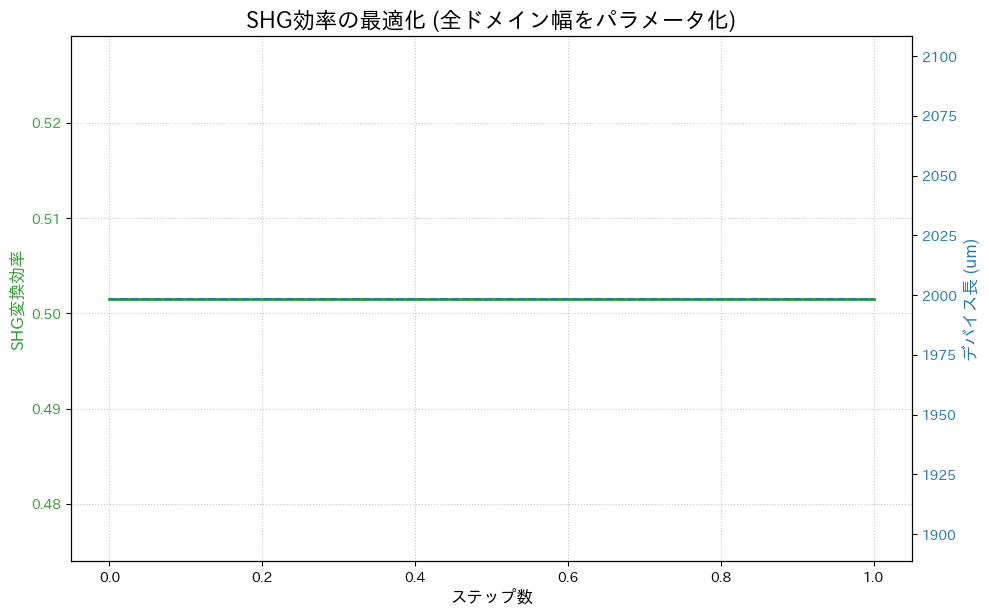

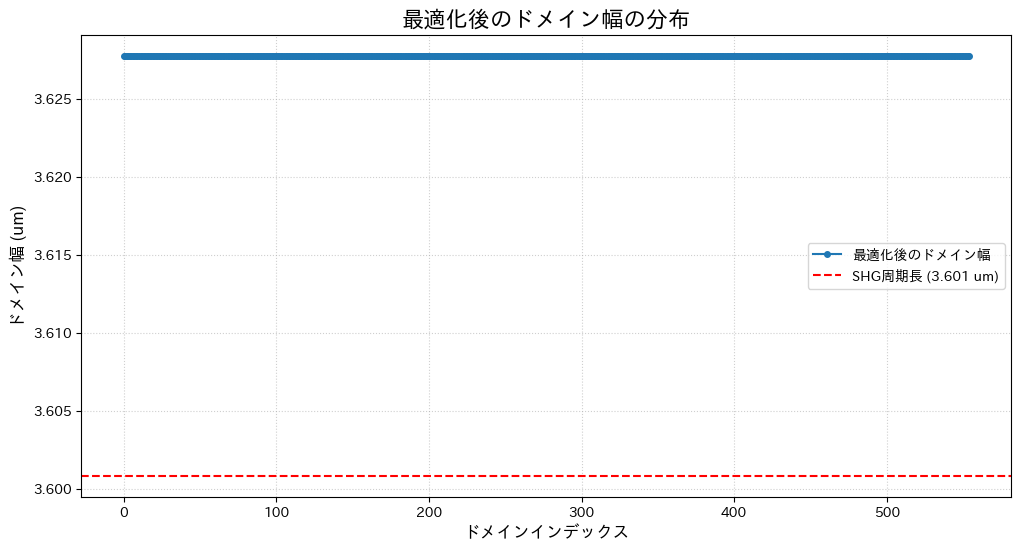

In [ ]:
import random
import jax
import jax.numpy as jnp
import optax
import matplotlib.pyplot as plt
import japanize_matplotlib
from tqdm import tqdm
import time

# ユーザー環境に qpm.mgoslt と qpm.cwes が存在することを前提とします
# from qpm import mgoslt, cwes

# --- 物理定数と設計パラメータ ---
KAPPA_MAG = jnp.arctanh(jnp.sqrt(0.95)) / 2000 * 2 / jnp.pi
DESIGN_TEMP_C = 70.0
DESIGN_WAVELENGTH = 1.031

# --- 位相不整合とドメイン数の計算 ---
DELTA_K_SHG = mgoslt.calc_twm_delta_k(
    DESIGN_WAVELENGTH, DESIGN_WAVELENGTH, DESIGN_TEMP_C)
DELTA_K_SFG = mgoslt.calc_twm_delta_k(
    DESIGN_WAVELENGTH, DESIGN_WAVELENGTH / 2.0, DESIGN_TEMP_C)
DOMAIN_LEN_SHG = jnp.pi / DELTA_K_SHG

# ドメイン数を目標デバイス長から計算して固定
TARGET_LENGTH = 2000.0
NUM_DOMAINS = int(jnp.round(TARGET_LENGTH / DOMAIN_LEN_SHG))
print(f"SHGドメイン幅: {DOMAIN_LEN_SHG:.3f} um")
print(f"固定ドメイン数: {NUM_DOMAINS}")

ALTERNATING_SIGN = jnp.power(-1.0, jnp.arange(NUM_DOMAINS))
# B_INITIAL = jnp.array([jnp.sqrt(0.5), jnp.sqrt(0.5), 0.0], dtype=jnp.complex64)
B_INITIAL = jnp.array([1.0, 0.0, 0.0], dtype=jnp.complex64)


def loss_and_aux_fn(domain_widths: jnp.ndarray):
    """
    各ドメイン幅の配列をパラメータとして受け取り、損失と補助データを返す。
    """
    # ドメイン幅が負の値になることを防ぐためsoftplusを適用（最適化の安定性向上）

    kappa_total = KAPPA_MAG * ALTERNATING_SIGN
    superlattice = jnp.stack([domain_widths, kappa_total], axis=1)

    efficiencies = cwes.simulate_twm(
        superlattice, DELTA_K_SHG, DELTA_K_SFG, B_INITIAL)

    shg_efficiency = efficiencies[0]
    loss = -shg_efficiency  # 変換効率の最大化 = 負の効率の最小化

    # 補助データとして、合計長と実際の効率を返す
    total_length = jnp.sum(domain_widths)
    return loss, (shg_efficiency, total_length)


def run_optimization():
    # --- ハイパーパラメータ ---
    learning_rate = 1.0
    num_steps = 200

    optimizer = optax.lbfgs(learning_rate)

    # --- 初期化 ---
    # 初期パラメータ: 全てのドメイン幅をSHG周期長で初期化
    key = jax.random.PRNGKey(0)
    initial_params = jax.random.uniform(
        key,
        shape=(NUM_DOMAINS,),  # 生成したい配列の形状
        minval=DOMAIN_LEN_SHG,
        maxval=DOMAIN_LEN_SHG
    )
    opt_state = optimizer.init(initial_params)
    params = initial_params

    # 【修正点1】 LBFGSの直線探索が要求する、損失値のみを返す関数を定義
    def value_fn(params):
        loss, _ = loss_and_aux_fn(params)
        return loss

    # 勾配計算とパラメータ更新を一つの関数にまとめる
    value_and_grad_fn = jax.value_and_grad(loss_and_aux_fn, has_aux=True)

    # 【修正点2】 JITコンパイル用のステップ関数を修正
    @jax.jit
    def optimization_step(params, opt_state):
        # 損失と勾配を計算 (これは一度だけでOK)
        (loss, aux_data), grads = value_and_grad_fn(params)

        # optimizer.update に必要な引数をすべて渡す
        updates, opt_state = optimizer.update(
            grads,
            opt_state,
            params,
            value=loss,          # キーワード引数 'value' を追加
            grad=grads,          # キーワード引数 'grad' を追加
            value_fn=value_fn    # キーワード引数 'value_fn' を追加
        )
        new_params = optax.apply_updates(params, updates)
        return new_params, opt_state, loss, aux_data

    # --- 最適化ループ ---
    history = {"shg_eff": [], "length": []}

    print("JITコンパイル中...（初回のみ時間がかかります）")
    # JITコンパイルのためのウォームアップ実行
    params, opt_state, loss, (shg_eff, current_length) = optimization_step(
        params, opt_state)
    print(current_length, shg_eff)
    print("最適化を開始します...")

    start_time = time.perf_counter()
    for _ in tqdm(range(num_steps)):
        params, opt_state, loss, (shg_eff, current_length) = optimization_step(
            params, opt_state)

        history["shg_eff"].append(shg_eff)
        history["length"].append(current_length)

    final_params = params
    jax.block_until_ready(final_params)
    end_time = time.perf_counter()
    print(f"最適化完了 ({num_steps}ステップ, {end_time - start_time:.3f} 秒)")

    # --- 結果表示 ---
    final_length = history["length"][-1]
    final_sfg_eff = history["shg_eff"][-1]

    print(f"\n最終的なデバイス長: {final_length:.1f} um")
    print(f"最終的なSFG変換効率: {final_sfg_eff:.4%}")

    # --- グラフ描画 ---
    # 1. 効率と全長の学習推移
    fig, ax1 = plt.subplots(figsize=(10, 6))
    color = 'tab:green'
    ax1.set_xlabel("ステップ数", fontsize=12)
    ax1.set_ylabel("SHG変換効率", fontsize=12, color=color)
    ax1.plot(jnp.array(history["shg_eff"]), color=color, lw=2, label='SHG効率')
    ax1.tick_params(axis='y', labelcolor=color)
    ax1.grid(True, linestyle=':', alpha=0.7)

    ax2 = ax1.twinx()
    color = 'tab:blue'
    ax2.set_ylabel("デバイス長 (um)", fontsize=12, color=color)
    ax2.plot(jnp.array(history["length"]),
             color=color, linestyle='--', label='デバイス長')
    ax2.tick_params(axis='y', labelcolor=color)

    fig.tight_layout()
    plt.title("SHG効率の最適化 (全ドメイン幅をパラメータ化)", fontsize=16)
    plt.show()

    # 2. 最適化後のドメイン幅の分布
    final_domain_widths = jax.nn.softplus(final_params)
    plt.figure(figsize=(12, 6))
    plt.plot(final_domain_widths, 'o-', markersize=4, label='最適化後のドメイン幅')
    plt.axhline(y=DOMAIN_LEN_SHG, color='r', linestyle='--',
                label=f'SHG周期長 ({DOMAIN_LEN_SHG:.3f} um)')
    plt.xlabel("ドメインインデックス", fontsize=12)
    plt.ylabel("ドメイン幅 (um)", fontsize=12)
    plt.title("最適化後のドメイン幅の分布", fontsize=16)
    plt.legend()
    plt.grid(True, linestyle=':', alpha=0.6)
    plt.show()


if __name__ == '__main__':
    run_optimization()